In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import japanize_matplotlib

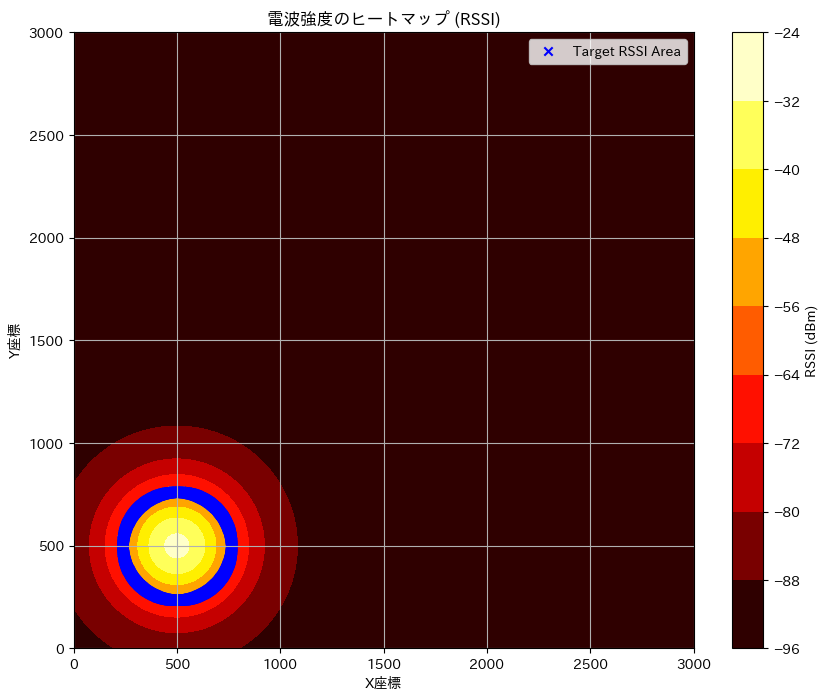

指定されたRSSI値(-60dBm)に近い座標数: 10493
絞り込んだ座標のサンプル:
[(734, 373), (598, 741), (384, 260), (585, 250), (752, 427), (241, 440), (764, 481), (361, 276), (755, 432), (311, 684)]


In [62]:
# 3000x3000の座標平面を作成
x = np.linspace(0, 3000, 3000)
y = np.linspace(0, 3000, 3000)
X, Y = np.meshgrid(x, y)

# 電波発信端末の座標とガウス分布のパラメータを設定
mu = [500, 500]  # 平均 (中心座標)
covariance_matrix = [[50000, 0], [0, 50000]]  # 共分散行列

# ガウス分布を計算
rv = multivariate_normal(mu, covariance_matrix)

# 各座標点での電波強度を計算
Z = rv.pdf(np.dstack((X, Y)))

# Zの最大値を取得
Z_max = np.max(Z)

# 実際のRSSI値にスケーリング (例: -30dBm から -90dBm の範囲)
RSSI_max = -90  # dBm
RSSI_min = -30  # dBm

# 正規化された Z を実際のRSSI値にスケーリング
# 中心に近づくほどRSSIが大きく（0に近く）、外側に行くほど小さく（負の値が大きく）なるようにする
RSSI = RSSI_max - (Z / Z_max) * (RSSI_max - RSSI_min)



# 指定されたRSSI値の座標を絞り込む
target_RSSI = -60  # 絞り込みたいRSSI値 (例: -60dBm)
tolerance = 0.5  # 許容誤差 (例: ±0.5dBm)

# 絞り込み条件に合致する座標を取得
indices = np.where((RSSI >= target_RSSI - tolerance) & (RSSI <= target_RSSI + tolerance))
filtered_coordinates = list(zip(X[indices], Y[indices]))

# 座標を丸める
rounded_coordinates = [(round(x), round(y)) for x, y in filtered_coordinates]

# 重複を削除
unique_coordinates = list(set(rounded_coordinates))

# プロット
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, RSSI, cmap='hot')
plt.colorbar(label='RSSI (dBm)')
plt.scatter(*zip(*unique_coordinates), color='blue', marker='x', label='Target RSSI Area')
plt.xlabel('X座標')
plt.ylabel('Y座標')
plt.title('電波強度のヒートマップ (RSSI)')
plt.legend()
plt.grid(True)
plt.show()

# 絞り込んだ座標の表示
print(f"指定されたRSSI値({target_RSSI}dBm)に近い座標数: {len(unique_coordinates)}")
if len(unique_coordinates) > 0:
    print("絞り込んだ座標のサンプル:")
    print(unique_coordinates[:10])  # 最初の10個を表示
else:
    print("指定されたRSSI値に近い座標が見つかりませんでした。")